# Compare group knockoffs

This simulation adapts the 4th simulation routine in section 5.1 of [Li and Mathius](https://academic.oup.com/jrsssb/article/83/3/534/7056103). Similar to [Spector and Janson](https://projecteuclid.org/journals/annals-of-statistics/volume-50/issue-1/Powerful-knockoffs-via-minimizing-reconstructability/10.1214/21-AOS2104.short), we also define the **ER(cov) and ER(prec)** model, where the first later model uses the precision matrix instead. 

+ target FDR = 10%
+ We generate equi, SDP, MVR, and ME group knockoffs using the true covariance matrix
+ Groups are defined via average linkake hierarchical clustering with cutoff 0.3

Simulation scripts



In [3]:
using Knockoffs
using LinearAlgebra
using Random
using StatsBase
using Statistics
using ToeplitzMatrices
using Distributions
using ProgressMeter
using CSV, DataFrames

# provides extra arguments for controlling CCD/PCA convergence criteria
function get_extra_args(method)
#     tol = occursin("sdp", string(method)) ? 0.00001 : 0.0001
    tol = 0.0001
    niter = 1000
    inner_pca_iter = 1
    inner_ccd_iter = 1
    outer_iter = round(Int, niter / (inner_pca_iter + inner_ccd_iter))
    if method ∈ [:maxent, :mvr]
        return (outer_iter=outer_iter, inner_pca_iter=inner_pca_iter, 
            inner_ccd_iter=inner_ccd_iter, tol=tol)
    elseif method == :sdp # sdp converges slower, so I use more stringent convergence 
        return (outer_iter=outer_iter, inner_pca_iter=inner_pca_iter, 
            inner_ccd_iter=inner_ccd_iter, tol=tol)
    elseif occursin("block", string(method)) # block update
        return (tol=tol, niter=niter)
    else
        return ()
    end
end
function run_group_knockoff_comparison(seed, n, cov::Bool)
    outdir = cov ? "/home/groups/sabatti/group_knockoff_simulations/ER_cov/n$(n)_marginal" : 
        "/home/groups/sabatti/group_knockoff_simulations/ER_prec/n$(n)_marginal"
    isdir(outdir) || mkpath(outdir)

    # simulation parameters
    target_fdr = 0.1
    m = 5
    p = 1000 # 500
    k = 50
    μ = zeros(p)
    fdr_target = 0.1
    knockoff_methods = [:equi, :sdp, :maxent, :mvr]
#     knockoff_methods = [:equi, :maxent]

    # simulate Σ
    Random.seed!(seed)
    Σ = simulate_ER(p, invert=!cov)

    # simulate X
    L = cholesky(Σ).L
    X = randn(n, p) * L
    zscore!(X, mean(X, dims=1), std(X, dims=1))

    # simulate y and beta
    βtrue = zeros(p)
    βtrue[1:k] .= randn(k)
    shuffle!(βtrue)
    ϵ = randn(n)
    y = X * βtrue + ϵ

    # define group
    groups = hc_partition_groups(X, cutoff=0.3)
    correct_groups = groups[findall(!iszero, βtrue)] |> unique
    @show length(unique(groups))

    df = DataFrame(method = Symbol[], power=Float64[], fdr=Float64[], time=Float64[], ssum=Float64[], obj=Float64[])
    for method in knockoff_methods
        # generate group knockoff
        extra_args = get_extra_args(method)
        Random.seed!(seed)
        my_t = @elapsed ko = modelX_gaussian_group_knockoffs(
            X, method, groups, μ, Σ,
            m=m; extra_args...
        )

        # feature statistic
        ko_filter = fit_marginal(y, ko, fdrs=[fdr_target])
        my_ssum = sum(abs.(ko.S))
        my_obj = ko.obj
        constraint = eigmin(Symmetric((m+1)/m*Σ - ko.S))
        if constraint < -0.0001
            @warn("min eval of (m+1)/m*Σ - S) is less than -0.0001")
        end

        # save output
        selected = ko_filter.selected[1]
        my_power = length(intersect(correct_groups, selected)) / length(correct_groups)
        my_fdr = length(setdiff(selected, correct_groups)) / max(1, length(selected))
        println("sim $seed $method: power = $(my_power), fdr = $(my_fdr), time = $(my_t), ssum = $(my_ssum), obj=$(my_obj), min eval = $constraint")
        push!(df, [method, my_power, my_fdr, my_t, my_ssum, my_obj])
    end
    CSV.write(joinpath(outdir, "sim$seed.csv"), df)

    return df
end

# seed = 1112
# cov = true
seed = parse(Int, ARGS[1])
cov = parse(Bool, ARGS[2])
for n in 250:250:1000
    df = run_group_knockoff_comparison(seed, n, cov)
end
println("finished.")


length(unique(groups)) = 817
sim 1112 equi: power = 0.0, fdr = 0.0, time = 4.595749119, ssum = 61.854379274701735, obj=1057.8845565114643, min eval = -5.705154287165753e-16


LoadError: InterruptException:

Submission script

In [1]:
function run_repeats(cov::Bool)
    simdir = "/home/groups/sabatti/group_knockoff_simulations"
    outdir = cov ? "/home/groups/sabatti/group_knockoff_simulations/ER_cov" : 
        "/home/groups/sabatti/group_knockoff_simulations/ER_prec"
    for sim in 1:100
        # create .sh file to submit jobs
        filename = "submit.sh"
        open(filename, "w") do io
            println(io, "#!/bin/bash")
            println(io, "#")
            println(io, "#SBATCH --job-name=er_$sim")
            println(io, "#")
            println(io, "#SBATCH --time=24:00:00")
            println(io, "#SBATCH --cpus-per-task=1")
            println(io, "#SBATCH --mem-per-cpu=12G")
            println(io, "#SBATCH --partition=owners,normal,candes,zihuai")
            println(io, "#SBATCH --output=$(outdir)/slurms/slurm-%j.out")
            println(io, "")
            println(io, "#save job info on joblog:")
            println(io, "echo \"Job \$JOB_ID started on:   \" `hostname -s`")
            println(io, "echo \"Job \$JOB_ID started on:   \" `date `")
            println(io, "")
            println(io, "# load the job environment:")
            println(io, "module load julia/1.8.4")
            println(io, "export JULIA_DEPOT_PATH=\"/home/groups/sabatti/.julia\"")
            println(io, "")
            println(io, "# run code")
            println(io, "echo 'julia $(simdir)/run_ER_marginal.jl $sim $cov'")
            println(io, "julia $(simdir)/run_ER_marginal.jl $sim $cov")
            println(io, "")
            println(io, "#echo job info on joblog:")
            println(io, "echo \"Job \$JOB_ID ended on:   \" `hostname -s`")
            println(io, "echo \"Job \$JOB_ID ended on:   \" `date `")
            println(io, "#echo \" \"")
        end
        # submit job
        run(`sbatch $filename`)
        println("submitted sim$sim") 
        rm(filename, force=true)
    end
end
for cov in [true, false]
    run_repeats(cov)
end

Submitted batch job 24261449
submitted sim1
Submitted batch job 24261451
submitted sim2
Submitted batch job 24261454
submitted sim3
Submitted batch job 24261456
submitted sim4
Submitted batch job 24261457
submitted sim5
Submitted batch job 24261458
submitted sim6
Submitted batch job 24261459
submitted sim7
Submitted batch job 24261461
submitted sim8
Submitted batch job 24261465
submitted sim9
Submitted batch job 24261467
submitted sim10
Submitted batch job 24261469
submitted sim11
Submitted batch job 24261471
submitted sim12
Submitted batch job 24261473
submitted sim13
Submitted batch job 24261475
submitted sim14
Submitted batch job 24261477
submitted sim15
Submitted batch job 24261479
submitted sim16
Submitted batch job 24261481
submitted sim17
Submitted batch job 24261482
submitted sim18
Submitted batch job 24261484
submitted sim19
Submitted batch job 24261485
submitted sim20
Submitted batch job 24261487
submitted sim21
Submitted batch job 24261488
submitted sim22
Submitted batch job

Submitted batch job 24261968
submitted sim84
Submitted batch job 24261970
submitted sim85
Submitted batch job 24261973
submitted sim86
Submitted batch job 24261976
submitted sim87
Submitted batch job 24261978
submitted sim88
Submitted batch job 24261982
submitted sim89
Submitted batch job 24261984
submitted sim90
Submitted batch job 24261987
submitted sim91
Submitted batch job 24261990
submitted sim92
Submitted batch job 24261993
submitted sim93
Submitted batch job 24261996
submitted sim94
Submitted batch job 24261999
submitted sim95
Submitted batch job 24262001
submitted sim96
Submitted batch job 24262005
submitted sim97
Submitted batch job 24262010
submitted sim98
Submitted batch job 24262013
submitted sim99
Submitted batch job 24262017
submitted sim100


## Make plots

n 250 has success success
n 500 has success success
n 750 has success success
n 1000 has success success


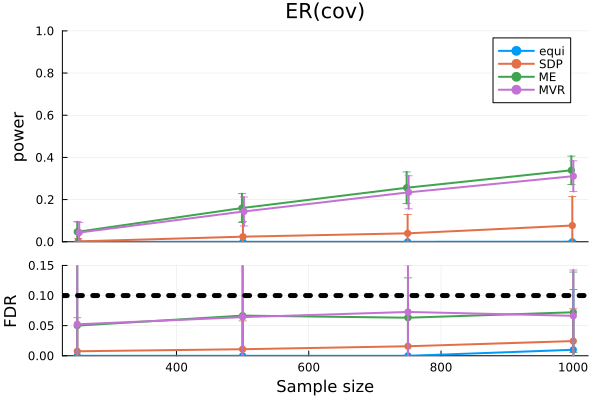

In [2]:
using ProgressMeter
using DataFrames, CSV
using Plots
using LinearAlgebra
using Statistics
gr(fmt=:png);

function summarize_er(cov::Bool, n::Int)
    dir = cov ? "/home/groups/sabatti/group_knockoff_simulations/ER_cov" :
        "/home/groups/sabatti/group_knockoff_simulations/ER_prec"
    equi_powers, equi_fdrs, equi_times, equi_ssums, equi_obj = [], [], [], [], []
    maxent_powers, maxent_fdrs, maxent_times, maxent_ssums, maxent_obj = [], [], [], [], []
    mvr_powers, mvr_fdrs, mvr_times, mvr_ssums, mvr_obj = [], [], [], [], []
    sdp_powers, sdp_fdrs, sdp_times, sdp_ssums, sdp_obj = [], [], [], [], []
    for seed in 1:100
        try
            result = CSV.read(joinpath(dir, "n$(n)_marginal", "sim$seed.csv"), DataFrame)
            push!(equi_powers, result[1, "power"]); push!(equi_fdrs, result[1, "fdr"])
            push!(sdp_powers, result[2, "power"]); push!(sdp_fdrs, result[2, "fdr"])
            push!(maxent_powers, result[3, "power"]); push!(maxent_fdrs, result[3, "fdr"])
            push!(mvr_powers, result[4, "power"]); push!(mvr_fdrs, result[4, "fdr"])
        catch
            continue
        end
    end
    println("n $n has $success success")
    return equi_powers, maxent_powers, mvr_powers, sdp_powers, 
        equi_fdrs, maxent_fdrs, mvr_fdrs, sdp_fdrs
end
function make_plot_er(cov::Bool; ns = 250:250:1000)
    equi_powers_mean, equi_fdrs_mean, equi_powers_std, equi_fdrs_std = [], [], [], []
    sdp_powers_mean, sdp_fdrs_mean, sdp_powers_std, sdp_fdrs_std = [], [], [], []
    maxent_powers_mean, maxent_fdrs_mean, maxent_powers_std, maxent_fdrs_std = [], [], [], []
    mvr_powers_mean, mvr_fdrs_mean, mvr_powers_std, mvr_fdrs_std = [], [], [], []

    # summarize results
    for n in ns
        equi_powers, maxent_powers, mvr_powers, sdp_powers, 
            equi_fdrs, maxent_fdrs, mvr_fdrs, sdp_fdrs = 
            summarize_er(cov, n)
        push!(equi_powers_mean, mean(equi_powers)); push!(equi_powers_std, std(equi_powers))
        push!(equi_fdrs_mean, mean(equi_fdrs)); push!(equi_fdrs_std, std(equi_fdrs))
        push!(sdp_powers_mean, mean(sdp_powers)); push!(sdp_powers_std, std(sdp_powers))
        push!(sdp_fdrs_mean, mean(sdp_fdrs)); push!(sdp_fdrs_std, std(sdp_fdrs))
        push!(maxent_powers_mean, mean(maxent_powers)); push!(maxent_powers_std, std(maxent_powers))
        push!(maxent_fdrs_mean, mean(maxent_fdrs)); push!(maxent_fdrs_std, std(maxent_fdrs))
        push!(mvr_powers_mean, mean(mvr_powers)); push!(mvr_powers_std, std(mvr_powers))
        push!(mvr_fdrs_mean, mean(mvr_fdrs)); push!(mvr_fdrs_std, std(mvr_fdrs))
    end

    # power plot
    title = cov ? "ER(cov)" : "ER(prec)"
    power_plt = plot(ns, equi_powers_mean, yerr=equi_powers_std, xtick=false, shape=:circle,
        ylabel="power", label="equi", w=2, ylim=(0, 1.0), title=title, markerstrokecolor=:auto, capsize = 0)
    plot!(ns, sdp_powers_mean, yerr=sdp_powers_std, label = "SDP", w=2, shape=:circle, markerstrokecolor=:auto, capsize = 0)
    plot!(ns .- 1.5, maxent_powers_mean, yerr=maxent_powers_std, label = "ME", w=2, shape=:circle, markerstrokecolor=:auto, capsize = 0)
    plot!(ns .+ 1.5, mvr_powers_mean, yerr=mvr_powers_std, label = "MVR", w=2, shape=:circle, markerstrokecolor=:auto, capsize = 0)

    # FDR plots
    fdr_plt = plot(ns, equi_fdrs_mean, xlabel="Sample size", yerr=equi_fdrs_std, 
        ylabel="FDR", label="equi", w=2, ylim=(0, 0.15), shape=:circle, markerstrokecolor=:auto, )
    plot!(ns, sdp_fdrs_mean, label = "SDP", w=2, shape=:circle, yerr=sdp_fdrs_std, markerstrokecolor=:auto)
    plot!(ns, maxent_fdrs_mean, label = "ME", w=2, shape=:circle, yerr=maxent_fdrs_std, markerstrokecolor=:auto)
    plot!(ns, mvr_fdrs_mean, label = "MVR", w=2, shape=:circle, yerr=mvr_fdrs_std, markerstrokecolor=:auto)
    hline!(fdr_plt, [0.1], label = "target FDR", linestyle=:dot, w=5, color=:black, legend=false)
    
    return power_plt, fdr_plt
end

ER_cov_power_plt, ER_cov_fdr_plt = make_plot_er(true)
plot(ER_cov_power_plt, ER_cov_fdr_plt, layout = grid(2, 1, heights=[0.7 ,0.3]))

n 250 has success success
n 500 has success success
n 750 has success success
n 1000 has success success


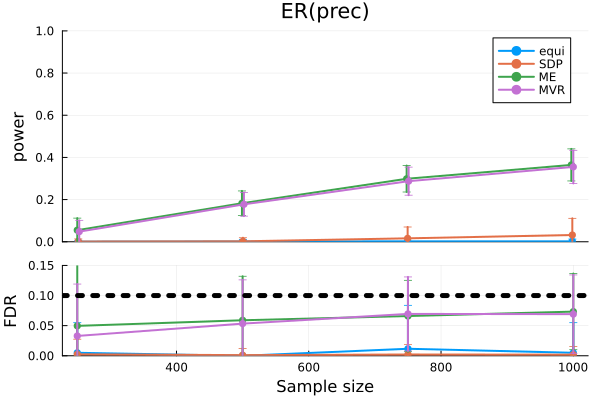

In [3]:
ER_cov_power_plt, ER_cov_fdr_plt = make_plot_er(false)
plot(ER_cov_power_plt, ER_cov_fdr_plt, layout = grid(2, 1, heights=[0.7 ,0.3]))